In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
# from astropy.visualization import ImageNormalize, LogStretch, SqrtStretch
# from matplotlib.colors import LogNorm, SymLogNorm, Normalize
# from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import tensorflow as tf
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.style.use("science") # requires SciencePlots
params = {'legend.fontsize': 27,
          'figure.figsize': (4, 4),
         'axes.labelsize': 27,
         'axes.titlesize': 30,
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'figure.titlesize': 20,
          'xtick.major.size': 8,
          'xtick.minor.size': 4,
         'xtick.major.width': 1,
          'xtick.minor.width': 1,
         'ytick.major.size': 8,
          'ytick.minor.size': 4,
         'ytick.major.width': 1,
          'ytick.minor.width': 1,

         }
pylab.rcParams.update(params)


2022-11-27 17:12:09.259564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-27 17:12:09.259591: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


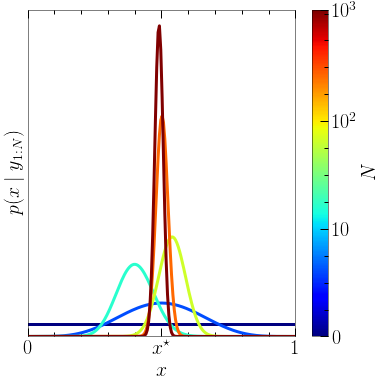

In [2]:
def likelihood(y, x):
    return x**y * (1 - x)**(1 - y)

def prior(x):
    out = np.zeros_like(x)
    out[(x >= 0) & (x <= 1)] = 1
    return out
    
def posterior(x, y):
    n = y.size
    return np.prod(likelihood(y, x), axis=1)

plt.figure(figsize=(6, 6))
Ns = [0, 10, 50, 100, 500, 1000]
x = np.linspace(0, 1, 200)[:, None]
for i, N in enumerate(Ns):
    y = np.random.choice(2, size=N)[None, :]
    plt.plot(x, posterior(x, y) / np.sum(posterior(x, y)), color=plt.cm.jet((i) /(len(Ns) - 1)), lw=3)

plt.ylabel(r"$p(x \mid y_{1:N})$", fontsize=20)
plt.xlabel(r"$x$", fontsize=20)
plt.xticks([0, 0.5, 1], ["0", r"$x^{\star}$", "1"])
plt.yticks([])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.jet))
cbar.ax.set_yticks([0, 0.33, 0.66, 1], labels=["0", "10", r"$10^2$", r"$10^3$"])
cbar.ax.set_ylabel(r"$N$", fontsize=20)
plt.xlim(0, 1)
plt.ylim(0)
plt.savefig("toy_coin_toss.pdf")

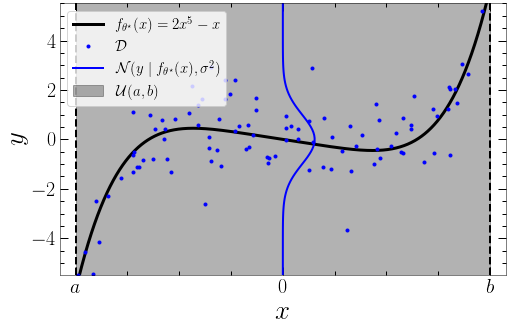

In [7]:
def f(x):
    return 2 * x**5 - x

def U(x, a, b):
    out = np.zeros_like(x)
    out[(x < a) | (x > b)] = 0
    out[(x >= a) & (x <= b)] = 1
    return out

def pyx(y, x, sigma=1):
    return np.exp(-0.5 * (y - f(x))**2/sigma**2) / np.sqrt(2 * np.pi) / sigma

def log_likelihood(x, y):
    return (f(x) - y)**2

a = -1.3
b = 1.3
sigma = 1

plt.figure(figsize=(8, 5))
true_x = np.linspace(a-0.1, b+0.1, 1000)
x = np.random.uniform(a, b, 100)
plt.plot(true_x, f(true_x), "k-", lw=3, label=r"$f_{\theta^\star}(x) = 2x^5 - x$")
plt.plot(x, f(x) + np.random.normal(size=x.size) * sigma, "b.", label=r"$\mathcal{D}$")
y = np.linspace(-5.5, 5.5, 100)
xs = np.zeros_like(y)
plt.plot(0.5*pyx(y, xs, sigma), y, color="b", label=r"$\mathcal{N}(y \mid f_{\theta^\star}(x), \sigma^2)$", lw=2)
# plt.plot(true_x, 5 * U(true_x, a, b))
plt.xlim(a-0.1, b + 0.1)
plt.ylim(-5.5, 5.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.xticks([a, 0, b], [fr"$a$", r"$0$", rf"$b$"])
plt.axvline(a, color="k", ls="--", lw=2)
plt.axvline(b, color="k", ls="--", lw=2)
plt.axvspan(xmin=a, xmax=b, ymax=5.5, ymin=-5.5, color="k", alpha=0.3, label=r"$\mathcal{U}(a, b)$")
plt.legend(fontsize=15, loc=2, facecolor="w", frameon=True)
plt.savefig("toy_problem.pdf")

In [1096]:
def model(x, theta):
    y = 0
    for i in range(theta.shape[0]):
        y += theta[i] * x**i
    return y

def gradient_descent(theta, B=100, N=100, gamma=1e-1, l2=0., l1=0., min_x=a, max_x=b, sigma=1):
    losses = []
    grads = []
    thetas = []
    for n in range(N):
        thetas.append(theta.numpy())
        with tf.GradientTape() as tape:
            tape.watch(theta)
            # sample new points from the distribution
            x = tf.random.uniform([B]) * (max_x - min_x) + min_x
            y_true = f(x) + tf.random.normal(shape=[x.shape[0]]) * sigma
            y = model(x, theta)
            loss = tf.reduce_mean((y_true - y)**2)
            loss += l1 * tf.reduce_mean(tf.math.abs(theta))
            loss += l2 * tf.reduce_mean(tf.square(theta))
            losses.append(loss.numpy())
        grad_theta = tape.gradient(loss, theta)
        grads.append(grad_theta.numpy())
        grad_theta = tf.minimum(grad_theta, tf.ones_like(grad_theta))
        grad_theta = tf.maximum(grad_theta, -tf.ones_like(grad_theta))
        theta -= gamma * grad_theta
    return theta, losses, thetas, grads

theta = tf.random.normal([6], stddev=1)
theta_star, losses, thetas, grads = gradient_descent(theta, B=1000, N=500, gamma=0.2, sigma=0.1)
theta_star

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ 0.00380436, -1.0943751 , -0.02981979,  0.23938784,  0.02094229,
        1.8764391 ], dtype=float32)>

(-2.0, 3.0)

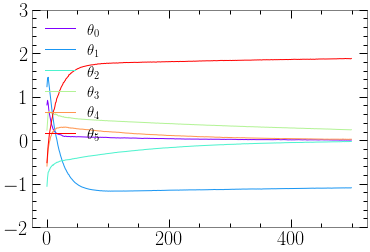

In [1097]:
plt.figure(figsize=(6, 4))
for i in range(theta_star.shape[0]):   
    plt.plot([x[i] for x in thetas], label=r"$\theta_{%d}$" % i, color=plt.cm.rainbow(i / (theta_star.shape[0] - 1)))
plt.legend(fontsize=15)
plt.ylim(-2, 3)

Text(0.5, 0, '$\\theta_1$')

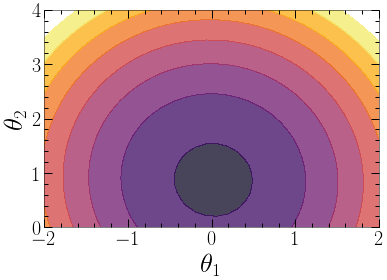

In [1098]:
def model_(x, theta1, theta2):
    return x[:, None, None] * theta2 + theta1 

def likelihood_(theta1, theta2, a=-1.2, b=1.2, B=1000):
    x = tf.random.uniform([B]) * (b - a) + a
    y_true = f(x)
    y = model_(x, theta1, theta2)
    return np.mean((y - y_true[:, None, None])**2, axis=0)

plt.figure(figsize=(6, 4))

theta1 = np.linspace(-2, 2, 32)
theta2 = np.linspace(0, 4, 32)
theta1, theta2 = np.meshgrid(theta1, theta2)
plt.contourf(theta1, theta2, likelihood_(theta1[None], theta2[None]), list(range(9)), alpha=.75, cmap=plt.cm.inferno)
# cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\mathcal{L}_\theta(\mathcal{D})$", fontsize=20)
plt.ylabel(r"$\theta_2$")
plt.xlabel(r"$\theta_1$")
# plt.quiver([x[0] for x in thetas], [x[1] for x in thetas], [-g[0] for g in grads], [-g[1] for g in grads], scale_units='xy', angles='xy', color="k", scale=1)


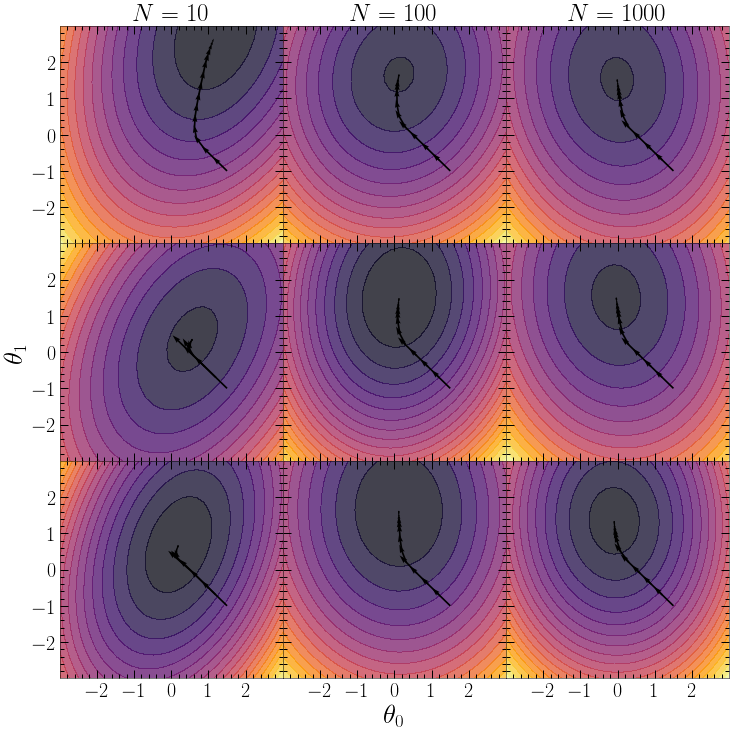

In [1107]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
theta1 = np.linspace(-3, 3, 32)
theta2 = np.linspace(-3, 3, 32)
theta1, theta2 = np.meshgrid(theta1, theta2)
Bs = [10, 100, 1000]


def gradient_descent_(x, y_true, theta, B=100, N=100, gamma=1e-1, l2=0., l1=0.):

    losses = []
    grads = []
    thetas = []
    for n in range(N):
        thetas.append(theta.numpy())
        with tf.GradientTape() as tape:
            tape.watch(theta)
            # sample new points from the distribution
            y = model(x, theta)
            loss = tf.reduce_mean((y_true - y)**2)
            loss += l1 * tf.reduce_mean(tf.math.abs(theta))
            loss += l2 * tf.reduce_mean(tf.square(theta))
            losses.append(loss.numpy())
        grad_theta = tape.gradient(loss, theta)
        grad_theta = tf.minimum(grad_theta, tf.ones_like(grad_theta))
        grad_theta = tf.maximum(grad_theta, -tf.ones_like(grad_theta))
        grads.append(grad_theta.numpy())
        theta -= gamma * grad_theta
    return theta, losses, thetas, grads

def likelihood_(x, y_true, theta1, theta2, a=-1.2, b=1.2, B=1000):
    y = model_(x, theta1, theta2)
    return np.mean((y - y_true[:, None, None])**2, axis=0)


theta_start = tf.constant([1.5, -1], dtype=tf.float32)
skip = 1
min_x=a
max_x=b
gamma = 0.3
for i in range(3):
    for j in range(3):
        x = tf.random.uniform([Bs[j]]) * (max_x - min_x) + min_x
        y_true = f(x) + tf.random.normal(shape=[x.shape[0]])
        theta, losses, thetas, grads = gradient_descent_(x, y_true, theta_start, B=Bs[j], N=15, gamma=gamma, l2=0., l1=0.)
        im = axs[i, j].contourf(theta1, theta2, likelihood_(x, y_true, theta1[None], theta2[None], B=Bs[j]), 20, alpha=.75, cmap=plt.cm.inferno)
        axs[i, j].set_xticks([-2, -1, 0, 1, 2])
        axs[i, j].set_yticks([-2, -1, 0, 1, 2])
        axs[0, j].set_title(r"$N= %.d$" % Bs[j], fontsize=25)
        axs[i, j].quiver([x[0] for x in thetas[::skip]], [x[1] for x in thetas[::skip]], [-gamma*g[0] for g in grads[::skip]], [-gamma*g[1] for g in grads[::skip]], scale_units='xy', angles='xy', color="k")

axs[1, 0].set_ylabel(r"$\theta_1$")
axs[-1, 1].set_xlabel(r"$\theta_0$")

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("monte_carlo_loss.pdf")

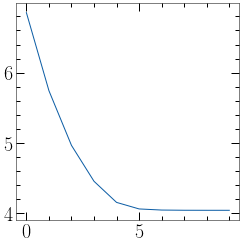

In [694]:
plt.plot(losses)

(-1.3, 1.3)

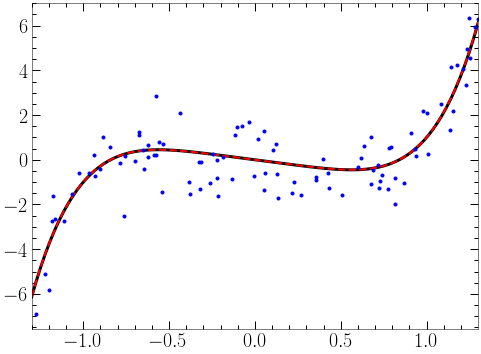

In [990]:
plt.figure(figsize=(8, 6))
true_x = np.linspace(a, b, 100)
x = np.random.uniform(a, b, 100)
plt.plot(true_x, f(true_x), "k-", lw=3)
plt.plot(true_x, model(true_x, theta_star), "r--", lw=2)
plt.plot(x, f(x) + np.random.normal(size=x.size), "b.")
plt.xlim(a, b)
# plt.ylim(-5, 5)

# Experiment 1: Complexity scaling, overfitting underfitting

In [1137]:
a = -1.3
b = 1.3
R = 20 # repeats for each experiments
gamma = 0.1
N = 200
B = 100
T = 100
P = 15
l0 = 0.
sigma = 1

theta_stars = {p: [] for p in range(1, P)}
thetas = {p: [] for p in range(1, P)}
losses = {p: [] for p in range(1, P)}
grads = {p: [] for p in range(1, P)}
g_ell = {p: 0 for p in range(1, P)}
g_ell_var = {p: 0 for p in range(1, P)}

for p in tqdm(range(1, P)):
    _ells = []
    for r in range(R):
        theta = tf.random.normal([p], stddev=0.1)
        x = tf.random.uniform([B]) * (b - a) + a
        y = f(x) + tf.random.normal(shape=[x.shape[0]]) * sigma
        theta_star, loss, theta, grad = gradient_descent_(x, y, theta, B=B, N=N, gamma=gamma, l2=0., l1=0)
        thetas[p].append(theta[-1])
        theta_stars[p].append(theta_star)
        losses[p].append(loss)
        grads[p].append(grad)
        x = tf.random.uniform([T]) * (b - a) + a
        y_true = f(x) + tf.random.normal(shape=[x.shape[0]]) * sigma
        y = model(x, theta_star)
        g_ell[p] += tf.reduce_mean((y_true - y)**2)
        _ells.append(tf.reduce_mean((y_true - y)**2))
    g_ell[p] /= R
    for r in range(R):
        g_ell_var[p] += (_ells[r] - g_ell[p])**2
    g_ell_var[p] /= R

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [05:08<00:00, 22.05s/it]


Text(0.5, 0, '$P$')

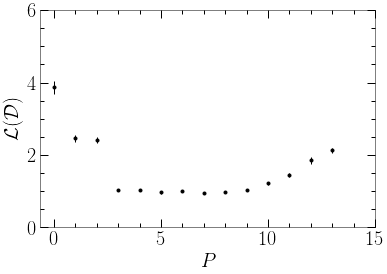

In [1135]:
plt.figure(figsize=(6, 4))
for p in range(1, P):
    ell = 0
    for r in range(R):
        ell += losses[p][r][-1]
    var = 0
    for r in range(R):
        var += (losses[p][r][-1] - ell / R)**2
#     print(np.sqrt(var) / R)
    plt.errorbar(p-1, ell / R, yerr=np.sqrt(var) / R, fmt=".", color="k")
plt.ylim(0, 6)
# plt.yscale("log")
plt.xticks([0, 5, 10, 15])
# plt.xlim(-0.5, 11.5)
plt.ylabel(r"$\mathcal{L}(\mathcal{D})$", fontsize=20)
plt.xlabel(r"$P$", fontsize=20)
# plt.savefig("bias_variance.pdf")

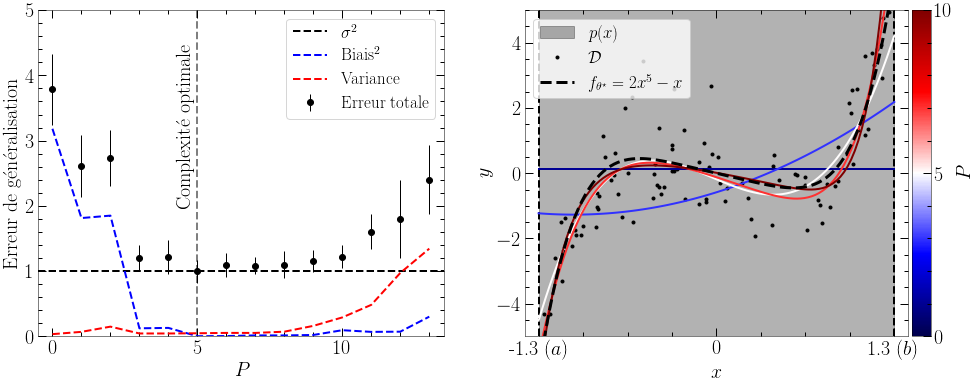

In [1252]:
cmap = plt.cm.seismic
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
true_x = np.linspace(a, b, T)
sampled_x = np.random.uniform(a, b, T)
x = np.linspace(a, b, T)
biais = []
variance = []


for p in range(1, P):
    ell = 0
    f_mean = 0
    theta_mean = 0
    for r in range(R):
        ell += losses[p][r][-1]
        f_mean += model(x, np.atleast_1d(thetas[p][r]))
        theta_mean += np.atleast_1d(thetas[p][r][-1])
#     biais.append(np.sqrt(np.mean((model(sampled_x, theta_mean) / R - f(sampled_x))**2)))
    biais.append(np.mean((f_mean / R - f(x))**2))
    var = 0
    f_var = 0
    for r in range(R):
        var += (losses[p][r][-1] - ell / R)**2
        f_var += (model(x, np.atleast_1d(thetas[p][r])) - f_mean / R)**2
#     print(np.sqrt(var) / R)
    variance.append(np.mean(f_var / R))
    if p == 1:
#         ax1.errorbar(p-1, ell / R, yerr=np.sqrt(var) / R, fmt="o", color="k", label=r"Erreur totale")
        ax1.errorbar(p-1, g_ell[p], yerr=np.sqrt(g_ell_var[p]), fmt="o", color="k", label=r"Erreur totale")
    else:
        ax1.errorbar(p-1, g_ell[p], yerr=np.sqrt(g_ell_var[p]), fmt="o", color="k")
#         ax1.errorbar(p-1, ell / R, yerr=np.sqrt(var) / R, fmt="o", color="k")

ax1.set_ylim(0, 5)
# plt.yscale("log")
ax1.set_xticks([0, 5, 10, 15])
ax1.set_xlim(-0.5, 13.5)
ax1.set_ylabel(r"Erreur de généralisation", fontsize=20)
ax1.set_xlabel(r"$P$", fontsize=20)
ax1.axvline(5, ls="--", lw=2, color="k", alpha=0.5)
ax1.annotate("Complexité optimale", color="k", xy=(4.3, 2), rotation=90, fontsize=20)
ax1.axhline(sigma**2, color="k", ls="--", lw=2, label=r"$\sigma^2$")
ax1.plot(biais, "b--", lw=2, label=r"Biais$^2$")
ax1.plot(variance, "r--", lw=2, label="Variance")

ax1.legend(loc=1, fontsize=17, frameon=True)


ax2.axvspan(xmin=a, xmax=b, ymax=5.5, ymin=-5.5, color="k", alpha=0.3, label=r"$p(x)$")
ax2.plot(sampled_x, f(sampled_x) + np.random.normal(size=sampled_x.size)*sigma, "k.", label=r"$\mathcal{D}$")
ax2.axvline(a, color="k", ls="--", lw=2)
ax2.axvline(b, color="k", ls="--", lw=2)


for p in [1, 3, 5, 7, 10]:
    ax2.plot(true_x, model(true_x, np.array(thetas[p][-1])), "-", color=cmap(p / 10), lw=2)
ax2.set_xlim(a-0.1, b+0.1)
ax2.set_ylim(-5, 5)
ax2.set_xlabel(r"$x$", fontsize=20)
ax2.set_ylabel(r"$y$", fontsize=20)
ax2.set_xticks([a, 0, b], [fr"{a} ($a$)", r"$0$", rf"{b} ($b$)"])
ax2.plot(true_x, f(true_x), "k--", lw=3, label=r"$f_{\theta^\star} = 2x^5 - x$")
ax2.legend(loc=2, fontsize=17, frameon=True)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cax, orientation='vertical')
# cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))
cbar.ax.set_yticks([0, 0.5, 1], labels=["0", r"$5$", r"$10$"])
cbar.ax.set_ylabel(r"$P$", fontsize=20)
plt.savefig("bias_variance.pdf")

# XOR

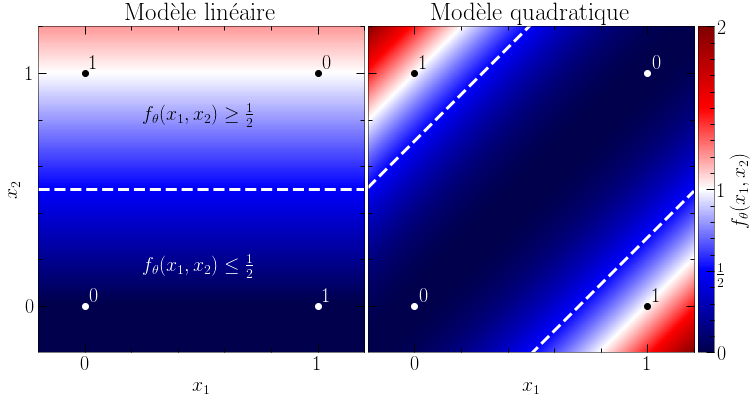

In [1237]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
cmap = "seismic"
xmin = -0.2
xmax = 1.2
_x = np.linspace(xmin, xmax, 128)
x, y = np.meshgrid(_x, _x[::-1], indexing='xy')
r2 = (y - x)**2
r1 = y



# plt.annotate()
ax1.imshow(r1, cmap=cmap,vmin=0, vmax=2, extent=[xmin, xmax, xmin, xmax])
ax2.imshow(r2, cmap=cmap, vmin=0, vmax=2, extent=[xmin, xmax, xmin, xmax])
ax2.plot(_x, _x + np.sqrt(0.5), "w--", lw=3)
ax2.plot(_x, _x - np.sqrt(0.5), "w--", lw=3)

ax1.axhline(0.5, lw=3, ls="--", color="w")
ax1.annotate(r"$f_\theta(x_1, x_2) \geq \frac{1}{2}$", xy=(0.25, 0.8), fontsize=20, color="k")
ax1.annotate(r"$f_\theta(x_1, x_2) \leq \frac{1}{2}$", xy=(0.25, 0.15), fontsize=20, color="w")

ax1.annotate("1", xy=(1+0.02, 0+0.02), fontsize=20, fontweight="bold", color="w")
ax1.annotate("1", xy=(0+0.02, 1+0.02), fontsize=20, fontweight="bold")
ax1.annotate("0", xy=(0+0.02, 0+0.02), fontsize=20, fontweight="bold", color="w")
ax1.annotate("0", xy=(1+0.02, 1+0.02), fontsize=20, fontweight="bold")
ax2.annotate("1", xy=(1+0.02, 0+0.02), fontsize=20, fontweight="bold")
ax2.annotate("1", xy=(0+0.02, 1+0.02), fontsize=20, fontweight="bold")
ax2.annotate("0", xy=(0+0.02, 0+0.02), fontsize=20, fontweight="bold", color="w")
ax2.annotate("0", xy=(1+0.02, 1+0.02), fontsize=20, fontweight="bold", color="w")
ax1.plot([1, 0], [1, 1], "ko")
ax1.plot([1, 0], [0, 0], "wo")
# ax2.plot(x, x, "w--")
ax2.plot([1, 0], [0, 1], "ko")
ax2.plot([1, 0], [1, 0], "wo")

ax1.set_ylabel(r"$x_2$", fontsize=20)
ax1.set_xlabel(r"$x_1$", fontsize=20)
ax1.set_xticks([0, 1], fontsize=17)
ax1.set_yticks([0, 1], fontsize=17)
# ax2.set_ylabel(r"$x_2$", fontsize=20)
ax2.set_xlabel(r"$x_1$", fontsize=20)
ax2.set_xticks([0, 1], fontsize=17)
ax2.set_yticks([0, 1], fontsize=17)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(xmin, xmax)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(xmin, xmax)

ax1.set_title("Modèle linéaire", fontsize=25)
ax2.set_title("Modèle quadratique", fontsize=25)

# plt.colorbar()
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cax, orientation='vertical')
# cbar = fig.colorbar(im, cax=cax, orientation="vertical")
cbar.ax.set_yticks([0, 0.25, 0.5, 1], labels=["0", r"$\frac{1}{2}$", r"$1$", r"$2$"])
cbar.ax.set_ylabel(r"$f_\theta(x_1, x_2)$", fontsize=20)
plt.subplots_adjust(wspace=-0.23, hspace=0)
plt.savefig("xor.pdf")